In [1]:
import time
import numpy as np
from robot_properties_talos.config import TalosConfig
from robot_properties_talos.taloswrapper import TalosRobot
from mpc.abstract_cyclic_gen1 import AbstractGaitGen

from controllers.robot_id_controller import InverseDynamicsController
from envs.pybullet_env import PyBulletEnv

import pinocchio as pin

import numpy as np
from motions.cyclic.talos_stand import still
from motions.weight_abstract import BiconvexMotionParams



<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<hpp::fcl::CollisionGeometry> already registered; second conversion method ignored.
pybullet build time: Dec  1 2021 18:33:43


In [2]:
robot = TalosConfig.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [42]:
## robot config and init
pin_robot = TalosConfig.buildRobotWrapper()
urdf_path = TalosConfig.urdf_path

eff_names = ["leg_right_sole1_fix_joint", "leg_right_sole2_fix_joint", "leg_left_sole1_fix_joint", "leg_left_sole2_fix_joint"]
hip_names = ["leg_left_1_joint", "leg_left_1_joint", "leg_right_1_joint", "leg_right_1_joint"]

# eff_names = ["l_leg_akx", "r_leg_akx"]
# hip_names = ["l_leg_hpz", "r_leg_hpz"]
n_eff = len(eff_names)

q0 = np.array(TalosConfig.initial_configuration)

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

v_des = np.array([0.2,0.0,0.0])
w_des = 0.0

plan_freq = 2 # sec
update_time = 0.0 # sec (time of lag)

In [43]:
gg = AbstractGaitGen(urdf_path, eff_names, hip_names, x0, plan_freq, q0)

robot_mass: 93.35572400000002


In [44]:
walk = BiconvexMotionParams("Talos", "walk")

# Cnt
walk.gait_period = 1.0
walk.stance_percent = 2*[0.6,] + 2*[0.6,]
walk.gait_dt = 0.2
walk.phase_offset = 2*[0.8,] + 2*[0.3,]

# IK
walk.state_wt = np.array([1e2, 1e2, 1e2] + [1e5] * 3 + [5e4,]*12 + [1e6,]*2 +\
                         [1e3] * (pin_robot.model.nv - 6 - 12 - 2) \
                         + [1e1] * 3 + [1e3] * 3 + [1e1] *(pin_robot.model.nv - 6))

walk.ctrl_wt = [0, 0, 1] + [5e2, 5e2, 5e2] + [5e2,]*12 + [1e6,]*2 +\
                         [1e1] * (pin_robot.model.nv - 6 - 12 - 2)

walk.swing_wt = [5e5, 1e4]
walk.cent_wt = [1e+2, 1e+1]
walk.step_ht = 0.1
walk.nom_ht = 0.9
walk.reg_wt = [5e-2, 1e-5]


# Dyn
walk.W_X =     np.array([1e1, 1e1, 1e+5, 1e+1, 1e+1, 2e+2, 1e+4, 1e+5, 1e4])
walk.W_X_ter = 10.*np.array([1e+5, 1e2, 1e+5, 1e+1, 1e+1, 2e+2, 1e+5, 1e+5, 1e+5])
walk.W_F = np.array(8*[1e1, 1e1,1e2])
walk.rho = 1e4

walk.ori_correction = [0.2, 0.2, 0.2]
walk.gait_horizon = 4

# Gains
walk.kp = np.array(12*[5e3,] + 2*[1e4,] + 4*[1e3,] + 2*[1e2,] + 8*[1e0,] + 4*[1e3,] \
                    + 2*[1e2,] + 8*[1e0,] + 2*[1e3,] )
walk.kd = np.array(12*[1e1,] + 2*[1.5e1,] + 4*[5e0,] + 2*[1e-1,] + 8*[0.005,] + 4*[5e0,]\
                     + 2*[1e0,] + 8*[0.005,] + 2*[5e0,] )

In [45]:
gg.update_gait_params(walk, 0)

Initialized Kino-Dyn planner


In [7]:
viz.viewer.jupyter_cell()

Cost Time : 0.0044977664947509766
Solve Time :  0.930938720703125
Maximum iterations reached 
Final norm: 0.0284134


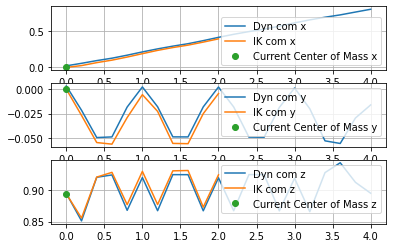

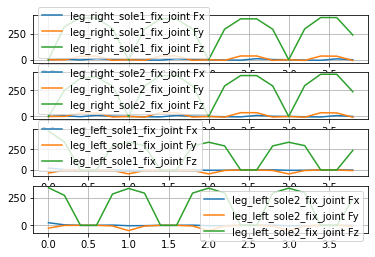

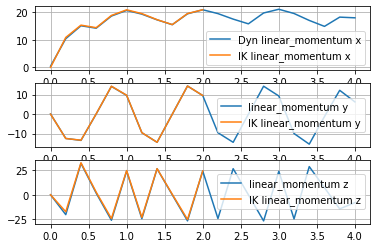

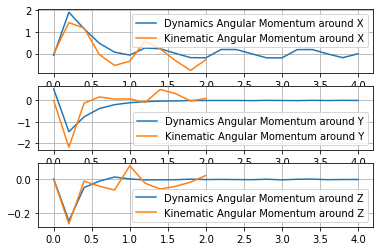

IndexError: index 1999 is out of bounds for axis 0 with size 1800

In [46]:
sim_t = 0.0
sim_dt = 0.001
index = 0
pln_ctr = 0
q = q0
v = v0

for o in range(1):
    xs, us, f = gg.optimize(q, v, sim_t, v_des, w_des)
    gg.plot(q, v)
    for ind in range(len(xs)):
        viz.display(xs[ind][:robot.model.nq])
        time.sleep(0.001)
    sim_t += plan_freq
    q = xs[int(plan_freq/sim_dt)-1][0:pin_robot.model.nq].copy()
    v = xs[int(plan_freq/sim_dt)-1][pin_robot.model.nq:].copy()


In [ ]:
i = 0
for names in rmodel.names[2:]:
    print(i, names)
    i += 1
print(i, rmodel.nq-7)

In [ ]:
rmodel.getFrameId("leg_right_sole_fix_joint")

In [9]:
rmodel

Nb joints = 46 (nq=51,nv=50)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 leg_left_1_joint: parent=1
  Joint 3 leg_left_2_joint: parent=2
  Joint 4 leg_left_3_joint: parent=3
  Joint 5 leg_left_4_joint: parent=4
  Joint 6 leg_left_5_joint: parent=5
  Joint 7 leg_left_6_joint: parent=6
  Joint 8 leg_right_1_joint: parent=1
  Joint 9 leg_right_2_joint: parent=8
  Joint 10 leg_right_3_joint: parent=9
  Joint 11 leg_right_4_joint: parent=10
  Joint 12 leg_right_5_joint: parent=11
  Joint 13 leg_right_6_joint: parent=12
  Joint 14 torso_1_joint: parent=1
  Joint 15 torso_2_joint: parent=14
  Joint 16 arm_left_1_joint: parent=15
  Joint 17 arm_left_2_joint: parent=16
  Joint 18 arm_left_3_joint: parent=17
  Joint 19 arm_left_4_joint: parent=18
  Joint 20 arm_left_5_joint: parent=19
  Joint 21 arm_left_6_joint: parent=20
  Joint 22 arm_left_7_joint: parent=21
  Joint 23 gripper_left_inner_double_joint: parent=22
  Joint 24 gripper_left_fingertip_1_joint: parent=23
  J